In [1]:
from accountmanager.Porfolio import Porfolio
from accountmanager.performance_metrics import plot_porfolio_performance, plot_confusion_matrix
from datadownloader.DataHandler import DataHandler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier

# I. Data:

In [3]:
handler = DataHandler()
handler.prepare_data(data_type='stock', codes=['AAPL'], 
                     columns=['Volume'], price_column='Adj Close', 
                     freq='daily')

D:\Workspace\Python\Jupyter_Notebook\AlgoResearchTool\datadownloader\DataHandler.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_data['Price'] = price_data


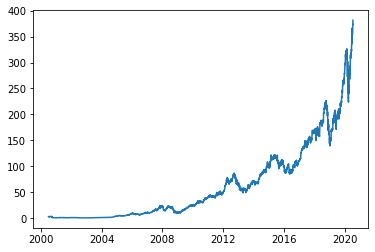

In [4]:
data = handler.get_updated_data(datetime.date(datetime.now()), nrows=-1)['AAPL']
plt.plot(data['Price'])
plt.show()

In [14]:
def create_lagged_dataset(ts, lags=1, lags_week=0, lags_month=0, lags_year=0, remove_nan=True):
    df = pd.DataFrame({'Today': ts})
    
    df['Today_Change'] = df['Today'].pct_change()
    for i in range(lags):
        df['Lag_Day_%s_Change' % str(i+1)] = df['Today_Change'].shift(i+1)
    
    for i in range(lags_week):
        df['Lag_Week_%s_Change' % str(i+1)] = df['Today_Change'].shift((i+1)*5)
        
    for i in range(lags_month):
        df['Lag_Month_%s_Change' % str(i+1)] = df['Today_Change'].shift((i+1)*21)
        
    for i in range(lags_year):
        df['Lag_Year_%s_Change' % str(i+1)] = df['Today_Change'].shift((i+1)*252)
    
    df.loc[df['Today_Change'].abs() < 0.01, 'Today_Change'] = 0.0
    
    if remove_nan:
        df = df.dropna(how='any')
    #df['Direction'] = np.sign(df['Today_Change'])
    df['Direction'] = 'Side-way'
    df.loc[df['Today_Change'] > 0.0,'Direction'] = 'Up'
    df.loc[df['Today_Change'] < 0.0,'Direction'] = 'Down'
    
    return df

aapl_close_lagged = create_lagged_dataset(data['Price'], lags=4, lags_week=2, lags_month=0, lags_year=1)

X = aapl_close_lagged[['Lag_Day_1_Change','Lag_Day_2_Change','Lag_Day_3_Change','Lag_Day_4_Change',
                       'Lag_Week_1_Change','Lag_Week_2_Change','Lag_Year_1_Change']]
y = aapl_close_lagged['Direction']

labels = np.array(np.unique(y), dtype='str')

In [15]:
train_start_date = datetime(2000, 1, 3)
train_end_date = datetime(2008, 1, 1)
eval_start_date = datetime(2008, 1, 2)
eval_end_date = datetime(2010, 1, 1)

X_train = X.loc[train_start_date:train_end_date]
y_train = y.loc[train_start_date:train_end_date]

X_test = X.loc[eval_start_date:eval_end_date]
y_test = y.loc[eval_start_date:eval_end_date]

# II. Strategy:

In [16]:
models = [
    ('LR', LogisticRegression(solver='liblinear')),
    ('GNB', GaussianNB()),
    ('QDA', QDA()),
    ('RSVM', SVC())
]

Accuracy: 0.396


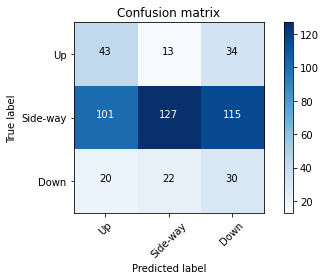

In [17]:
eclf = VotingClassifier(estimators=models, voting='hard')
eclf.fit(X_train, y_train)

pred = eclf.predict(X_test)
print('Accuracy: %0.3f' % (eclf.score(X_test, y_test)))

plot_confusion_matrix(confusion_matrix(pred, y_test), classes=['Up', 'Side-way', 'Down'],
                      title='Confusion matrix')

In [18]:
porfolio = Porfolio(starting_capital=10000)

date = handler.get_next_trading_date(datetime(2010, 1, 1))

for i in range(10*252):
    current_data = handler.get_updated_data(date, nrows=1) 
    
    current_X = X.loc[date].to_numpy().reshape(1, -1)
    
    predict_direction = eclf.predict(current_X)
    
    if predict_direction == 'Up': # Buy signal
        current_capital = porfolio.get_current_capital()
        current_price = current_data['AAPL']['Price']
        
        slot_size = int(current_capital / current_price / 10) * 10
        
        porfolio.update_trading_history(date, 'AAPL', slot_size, current_data['AAPL']['Price'])
    elif predict_direction == 'Down': # Sell signal    
        holding_quantity = porfolio.get_tickers_in_porfolio().get('AAPL', 0)
        
        porfolio.update_trading_history(date, 'AAPL', -holding_quantity, current_data['AAPL']['Price'])
    
    porfolio.update_value_history(date, current_data)
    
    date = handler.get_next_trading_date(date, n=1)

# Porfolio Performance:

In [19]:
porfolio_perf = porfolio.get_porfolio_performance(N=252)
porfolio_perf

{'Value History': Date
 2010-01-05     10000.000
 2010-01-06     10000.000
 2010-01-07     10000.000
 2010-01-08     10000.000
 2010-01-11     10000.000
                  ...    
 2020-01-02    113609.584
 2020-01-03    112505.570
 2020-01-06    113401.648
 2020-01-07    112868.546
 2020-01-08    114683.388
 Name: Value, Length: 2520, dtype: float64,
 'Rate of Return History ': Date
 2010-01-05         NaN
 2010-01-06    0.000000
 2010-01-07    0.000000
 2010-01-08    0.000000
 2010-01-11    0.000000
                 ...   
 2020-01-02    0.022806
 2020-01-03   -0.009718
 2020-01-06    0.007965
 2020-01-07   -0.004701
 2020-01-08    0.016079
 Name: Value, Length: 2520, dtype: float64,
 'Current Value': 114683.38799999999,
 'Total Growth': 10.4683388,
 'Annualized Rate of Return': 0.277076143034063,
 'Sharpe Ratio': 0.8858625832796679,
 'Drawdowns':                     TS        Peak  Drawdown  Drawdown %  Duration
 Date                                                              
 201

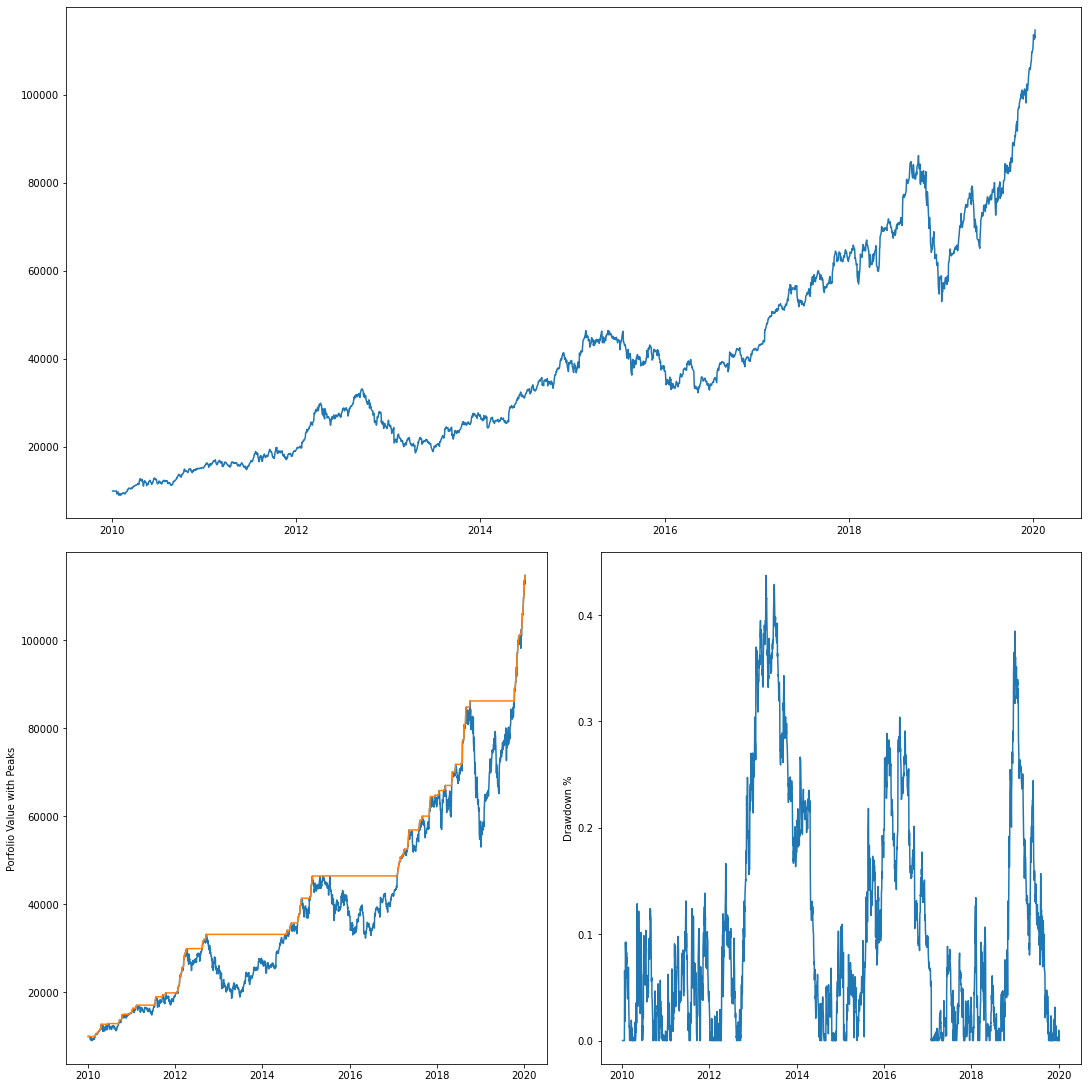

In [20]:
plot_porfolio_performance(porfolio_perf)

# Compare to Buy and Hold:

In [12]:
porfolio = Porfolio(starting_capital=10000)

date = handler.get_next_trading_date(datetime(2010, 1, 1))
current_data = handler.get_updated_data(date, nrows=1) 
current_capital = porfolio.get_current_capital()
current_price = current_data['AAPL']['Price']
slot_size = int(current_capital / current_price / 10) * 10
porfolio.update_trading_history(date, 'AAPL', slot_size, current_data['AAPL']['Price'])

for i in range(10*252):
    current_data = handler.get_updated_data(date, nrows=1) 
    
    porfolio.update_value_history(date, current_data)
    
    date = handler.get_next_trading_date(date, n=1)
    
porfolio_perf = porfolio.get_porfolio_performance(N=252)
porfolio_perf

{'Value History': Date
 2010-01-05     10000.000
 2010-01-06      9843.971
 2010-01-07      9826.100
 2010-01-08      9890.184
 2010-01-11      9804.603
                  ...    
 2020-01-02    110761.508
 2020-01-03    109686.547
 2020-01-06    110559.044
 2020-01-07    110039.971
 2020-01-08    111807.054
 Name: Value, Length: 2520, dtype: float64,
 'Rate of Return History ': Date
 2010-01-05         NaN
 2010-01-06   -0.015603
 2010-01-07   -0.001815
 2010-01-08    0.006522
 2010-01-11   -0.008653
                 ...   
 2020-01-02    0.022776
 2020-01-03   -0.009705
 2020-01-06    0.007954
 2020-01-07   -0.004695
 2020-01-08    0.016059
 Name: Value, Length: 2520, dtype: float64,
 'Current Value': 111807.054,
 'Total Growth': 10.1807054,
 'Annualized Rate of Return': 0.27433798312394975,
 'Sharpe Ratio': 0.8777483831153178,
 'Drawdowns':                     TS        Peak  Drawdown  Drawdown %  Duration
 Date                                                              
 2010-01-0

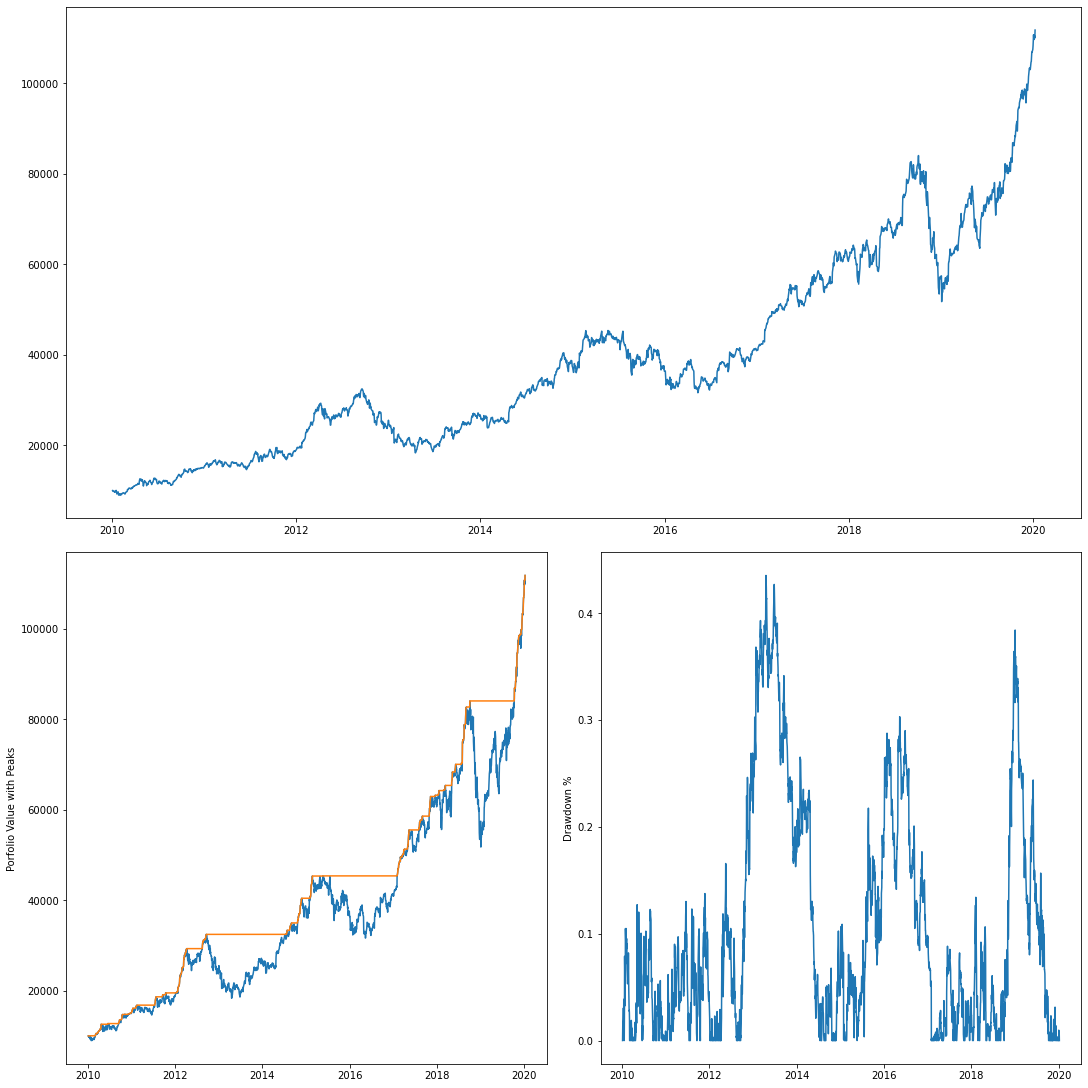

In [13]:
plot_porfolio_performance(porfolio_perf)